In [1]:
import scanpy as sc
import anndata as ad
import scanpy.external as sce
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import warnings
import seaborn as sns
from scipy.signal import find_peaks
import pandas as pd
import random as rd
warnings.filterwarnings("ignore") 

In [2]:
scanpal = ['#008080', '#FFFBFA', '#A86E27', '#7D0000', '#A9FEC1', '#817E00', '#EEC1BF', '#000080', '#808080', '#F9BFBD', '#FCDF1A', '#E4194C', '#FDBDA5', '#931DB8', '#47F0F0', '#ED32E5', 
          '#D2F340', '#954DA3', '#999999', '#E11A1D', '#DDDE00', '#A55428', '#387FBA', '#FE7F00', '#D1AA94', '#F780C1']

In [3]:
magma = plt.cm.get_cmap('magma', 256)
magma_colors = magma(np.linspace(0, 1, 256))
grey = np.array([[0.8, 0.8, 0.8, 1.0]])
new_colors = np.vstack((grey, magma_colors[20:])) 
custom_cmap1 = ListedColormap(new_colors)

In [4]:
def condition_stacked_bar_plot(
    adata,
    category_key: str,
    condition_key: str,
    cond1: str,
    cond2: str,
    save = None,
    figsize=(14, 6),
    rotation=45
):
    # Compute percentages
    df = (
        adata.obs
        .groupby([category_key, condition_key])
        .size()
        .unstack(fill_value=0)
    )
    pct = df.div(df.sum(axis=1), axis=0) * 100
    clusters = pct.index.tolist()
    cond1_pct = pct[cond1].values
    cond2_pct = pct[cond2].values

    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    inds = np.arange(len(clusters))
    bar_width = 0.6

    ax.bar(inds, cond1_pct, bar_width, label=cond1, color='#E41A1C')
    ax.bar(inds, cond2_pct, bar_width, bottom=cond1_pct, label=cond2, color='#E5C494')

    # Tidy up axes & labels
    ax.set_xticks(inds)
    ax.set_xticklabels(clusters, rotation=rotation, ha='right', rotation_mode='anchor')
    ax.set_ylabel('Percentage')
    ax.set_xlabel('Cluster')
    ax.set_title(f'Percentage of {cond1} vs {cond2} Cells per Cluster')
    ax.legend()

    plt.tight_layout()
    if save != None: 
        plt.savefig(save, dpi=300)
    plt.show()
    

In [5]:
#THIS ASSUMES ADATA.RAW IS LOG-TRANSFORMED
def get_deg_table_with_cluster_column(adata, groupby='leiden', cluster=None):
    sc.tl.rank_genes_groups(adata, groupby=groupby, method='wilcoxon', use_raw=True)
    degs = sc.get.rank_genes_groups_df(adata, group=None, pval_cutoff=None)
    degs = degs.rename(columns={
        'group': 'group',
        'names': 'gene',
        'logfoldchanges': 'log2FoldChange',
        'pvals': 'pvalue',
        'pvals_adj': 'padj',
        'scores': 'stat'
    })
    return degs[['group', 'gene', 'log2FoldChange', 'stat', 'pvalue', 'padj']]

In [6]:
#THIS ASSUMES ADATA.RAW IS LOG-TRANSFORMED
def get_deg_table(adata, groupby='leiden', cluster=None):
    sc.tl.rank_genes_groups(adata, groupby=groupby, method='wilcoxon', use_raw=True)
    degs = sc.get.rank_genes_groups_df(adata, group=cluster, pval_cutoff=None)
    degs = degs.rename(columns={
        'names': 'gene',
        'logfoldchanges': 'log2FoldChange',
        'pvals': 'pvalue',
        'pvals_adj': 'padj',
        'scores': 'stat'
    })
    return degs[['gene', 'log2FoldChange', 'stat', 'pvalue', 'padj']]

In [7]:
adata = sc.read_mtx('input/matrix.mtx').T

In [8]:
barcodes = pd.read_csv('input/barcodes.tsv', sep='\t', header=None)

In [9]:
adata.obs_names = np.array(barcodes.iloc[:,0])

In [10]:
features = pd.read_csv('input/genes.tsv', sep='\t', header=None)

In [11]:
adata.var_names = np.array(features.iloc[:,1])

In [12]:
adata.obs['batch'] = adata.obs_names.str.split('_').str[0]

In [13]:
sample_info = pd.read_excel('sample_information.xlsx')

In [14]:
batch_to_condition ={}

for i in range(len(sample_info.index)): 
    batch_to_condition[str(sample_info.iloc[i, 0])] = sample_info.iloc[i, 1]

In [15]:
adata.obs['batch1'] = adata.obs['batch'].str[1:]

In [16]:
adata.obs['condition'] = adata.obs['batch1'].map(batch_to_condition)

In [17]:
batch_to_location={}
for i in range(len(sample_info.index)): 
    batch_to_location[str(sample_info.iloc[i, 0])] = sample_info.iloc[i, 3]

In [18]:
adata.obs['location'] = adata.obs['batch1'].map(batch_to_location)

In [19]:
# Mark mitochondrial
adata.var['mt'] = adata.var_names.str.startswith("MT-")
# Calculate QC metrics
sc.pp.calculate_qc_metrics(
    adata,
    qc_vars=['mt'],
    percent_top=None,
    log1p=False,
    inplace=True
)

In [20]:
sc.pp.normalize_total(adata, target_sum=10000)
sc.pp.log1p(adata)

In [458]:
gadata = adata.copy()

In [459]:
sc.pp.highly_variable_genes(
    adata,
    flavor='seurat',
    batch_key='batch',
    n_top_genes=2500
)
adata.raw = adata.copy()
adata = adata[:, adata.var.highly_variable].copy()

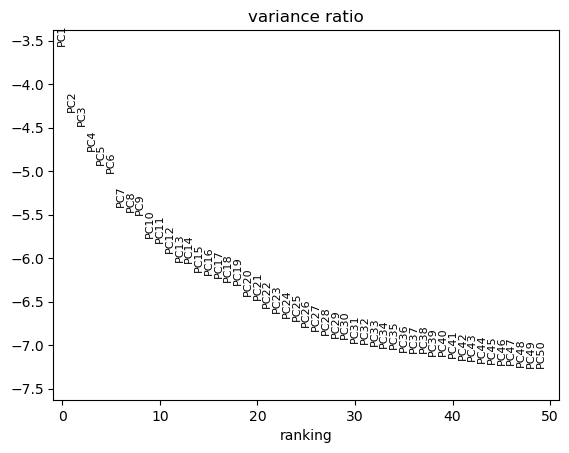

In [460]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

In [461]:
sc.external.pp.harmony_integrate(adata, key='batch', max_iter_harmony=30)
sc.pp.neighbors(adata, n_neighbors = 30, n_pcs = 50, use_rep='X_pca_harmony')
sc.tl.umap(adata)

2025-07-17 18:45:23,363 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-07-17 18:45:25,993 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-07-17 18:45:26,087 - harmonypy - INFO - Iteration 1 of 30
2025-07-17 18:45:31,138 - harmonypy - INFO - Iteration 2 of 30
2025-07-17 18:45:35,883 - harmonypy - INFO - Iteration 3 of 30
2025-07-17 18:45:40,662 - harmonypy - INFO - Iteration 4 of 30
2025-07-17 18:45:45,429 - harmonypy - INFO - Iteration 5 of 30
2025-07-17 18:45:50,126 - harmonypy - INFO - Iteration 6 of 30
2025-07-17 18:45:55,062 - harmonypy - INFO - Iteration 7 of 30
2025-07-17 18:45:59,857 - harmonypy - INFO - Converged after 7 iterations


In [462]:
sc.tl.leiden(adata, resolution=3.5)

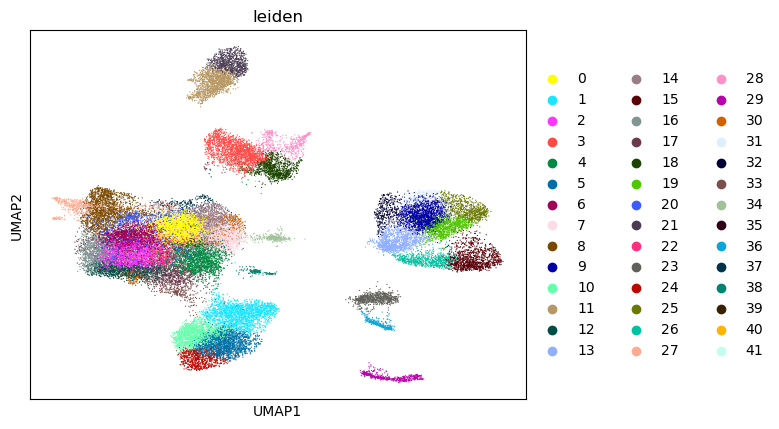

In [469]:
sc.pl.umap(adata, color=['leiden'], save='all_cells_leiden.png')

In [348]:
supp2 = pd.read_excel('celltype_markers.xlsx')

In [349]:
supp2 = supp2.loc[supp2['Compartment']=='Stromal', ['Cell subset name', 'Markers']]

In [351]:
markers = {
    row['Cell subset name']: row['Markers']
    for _, row in supp2.iterrows()
}

In [352]:
import ast

supp2['Markers'] = supp2['Markers'].apply(ast.literal_eval)

In [353]:
markers = {
    row['Cell subset name']: row['Markers']
    for _, row in supp2.iterrows()
}

In [464]:
leiden_to_celltype = {
    '0': 'Fibroblasts ADAMDEC1+',
    '1': 'Fibroblasts NPY+ SLITRK6+',
    '2': 'Fibroblasts ADAMDEC1+',
    '3': 'Myofibroblasts HHIP+ NPNT+',
    '4': 'Fibroblasts ADAMDEC1+',
    '5': 'Fibroblasts NPY+ SLITRK6+',
    '6': 'Fibroblasts ADAMDEC1+',
    '7': 'Fibroblasts ADAMDEC1+',
    '8': 'Fibroblasts ADAMDEC1+',
    '9': 'Endothelial cells CD36+',
    '10': 'Fibroblasts NPY+ SLITRK6+',
    '11': 'Glial cells',
    '12': 'Fibroblasts ADAMDEC1+',
    '13': 'Endothelial cells CD36+',
    '14': 'Fibroblasts ADAMDEC1+',
    '15': 'Endothelial cells DARC+',
    '16': 'Fibroblasts ADAMDEC1+',
    '17': 'Fibroblasts ADAMDEC1+',
    '18': 'Myofibroblasts HHIP+ NPNT+',
    '19': 'Endothelial cells CD36+',
    '20': 'Activated fibroblasts CCL19+ ADAMADEC1+',
    '21': 'Glial cells',
    '22': 'Fibroblasts ADAMDEC1+',
    '23': 'Pericytes HIGD1B+ STEAP4+',
    '24': 'Fibroblasts SMOC2+ PTGIS+',
    '25': 'Endothelial cells CD36+',
    '26': 'Endothelial cells DARC+',
    '27': 'Fibroblasts SFRP2+ SLPI+',
    '28': 'Myofibroblasts GREM1+ GREM2+',
    '29': 'Lymphatics',
    '30': 'Fibroblasts ADAMDEC1+',
    '31': 'Endothelial cells CD36+',
    '32': 'Endothelial cells LTC4S+ SEMA3G+',
    '33': 'Inflammatory fibroblasts IL11+ CHI3L1+',
    '34': 'Fibroblasts ADAMDEC1+',
    '35': 'Fibroblasts ADAMDEC1+',
    '36': 'Pericytes RERGL+ NTRK2+',
    '37': 'Fibroblasts KCNN3+ LY6H+',
    '38': 'Stromal Cycling cells',
    '39': 'Fibroblasts ADAMDEC1+',
    '40': 'Fibroblasts ADAMDEC1+',
    '41': 'Fibroblasts ADAMDEC1+'
}

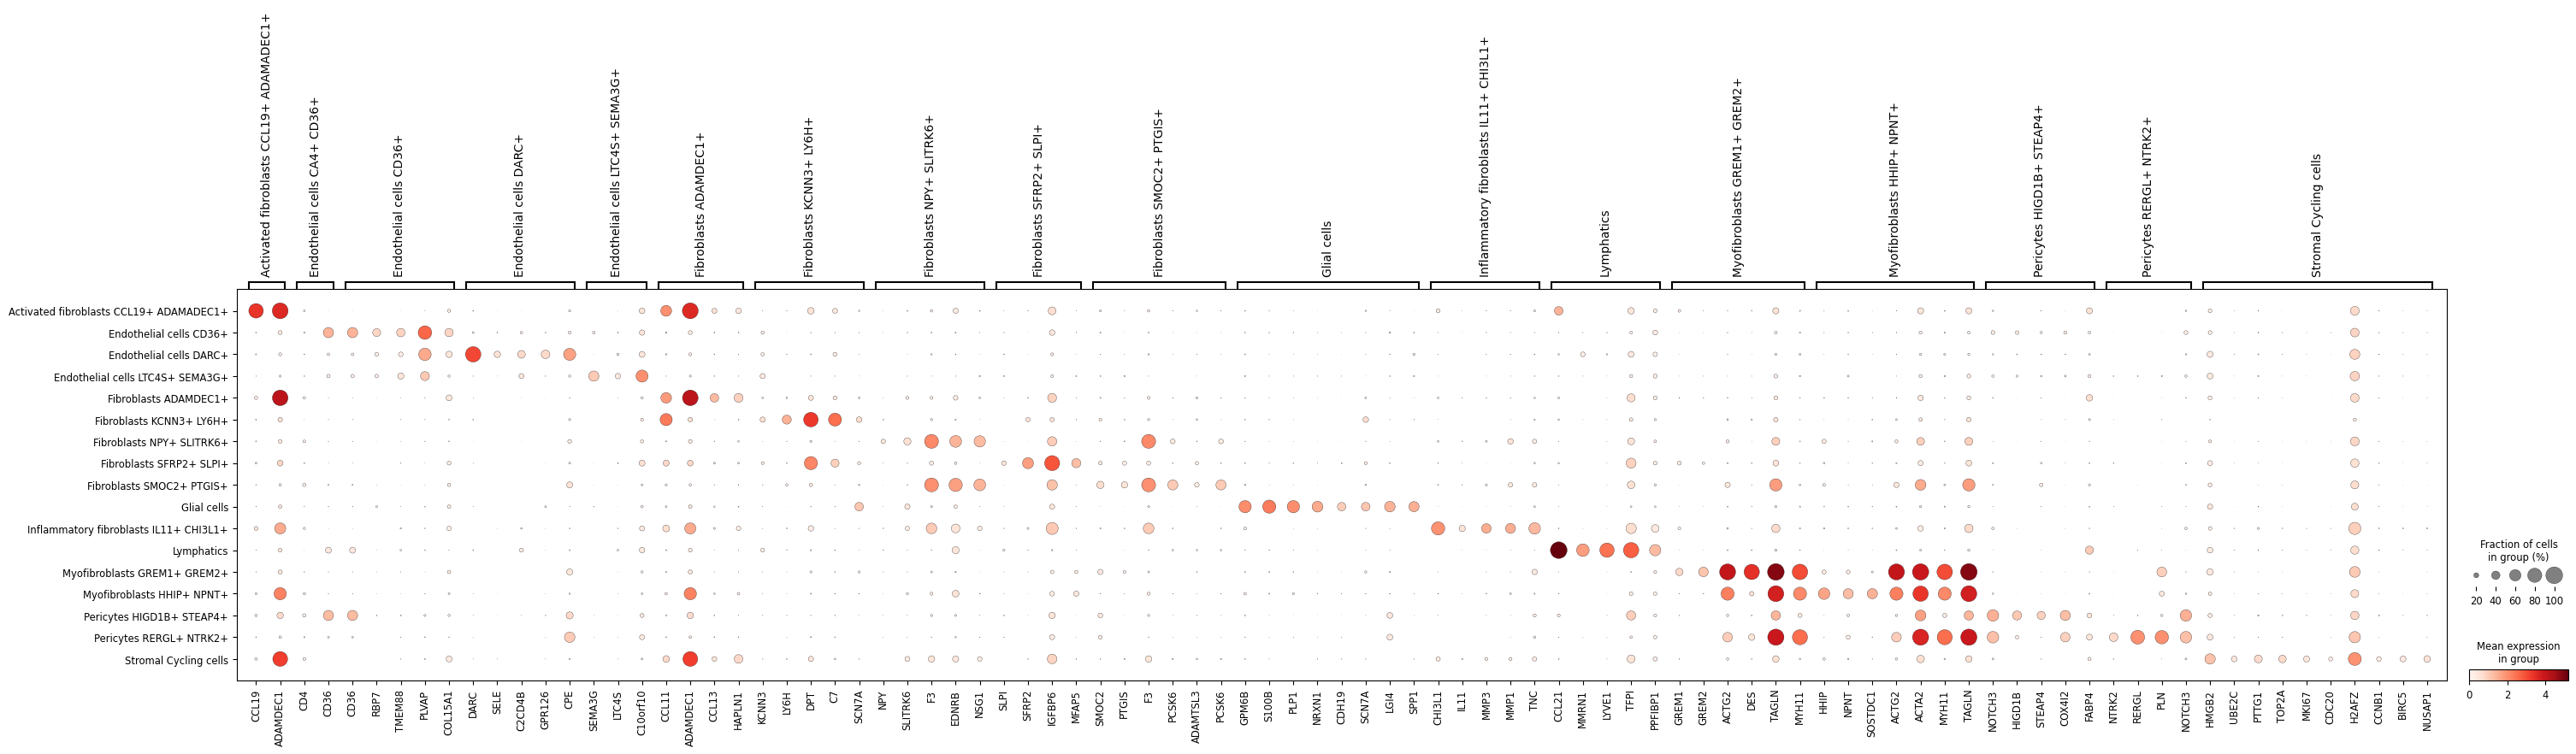

In [478]:
sc.pl.dotplot(adata, markers, 'celltype', save='dotplot_all_cells_markers_celltype')

In [465]:
adata.obs['celltype'] = adata.obs['leiden'].map(leiden_to_celltype)

In [58]:
meta_file = pd.DataFrame(columns=['barcodes_sample', 'cell_type'])

In [59]:
meta_file['barcodes_sample'] = adata.obs_names

In [60]:
meta_file['cell_type'] = np.array(adata.obs['celltype'])

In [84]:
meta_file.to_csv('cellphonedb_input/meta_file.csv',index=None)

In [62]:
len(adata.obs['celltype'].unique())

18

In [92]:
log_normalised_counts_cd = gadata.copy()

In [93]:
log_normalised_counts_cd.uns = {}

In [94]:
log_normalised_counts_cd.obs = log_normalised_counts_cd.obs.drop(columns=log_normalised_counts_cd.obs.columns)

In [95]:
log_normalised_counts_cd.var = log_normalised_counts_cd.var.drop(columns=log_normalised_counts_cd.var.columns)

In [96]:
log_normalised_counts_cd = log_normalised_counts_cd[adata.obs['condition'] == 'CD']

In [105]:
sc.write('cellphonedb_input/log_normalised_counts_cd.h5ad',log_normalised_counts_cd)

In [97]:
meta_file_cd = pd.DataFrame(columns=['barcodes_sample', 'cell_type'])

In [101]:
meta_file_cd['barcodes_sample'] = adata.obs_names[adata.obs['condition'] == 'CD']

In [102]:
meta_file_cd['cell_type'] = np.array(adata.obs['celltype'][adata.obs['condition']=='CD'])

In [104]:
meta_file_cd.to_csv('cellphonedb_input/meta_file_cd.csv', index=None)

In [71]:
log_normalised_counts = gadata.copy()

In [77]:
log_normalised_counts.uns = {}

In [80]:
log_normalised_counts.obs = log_normalised_counts.obs.drop(columns=log_normalised_counts.obs.columns)

In [81]:
log_normalised_counts.var = log_normalised_counts.var.drop(columns=log_normalised_counts.var.columns)

In [83]:
sc.write('cellphonedb_input/log_normalised_counts.h5ad',log_normalised_counts)

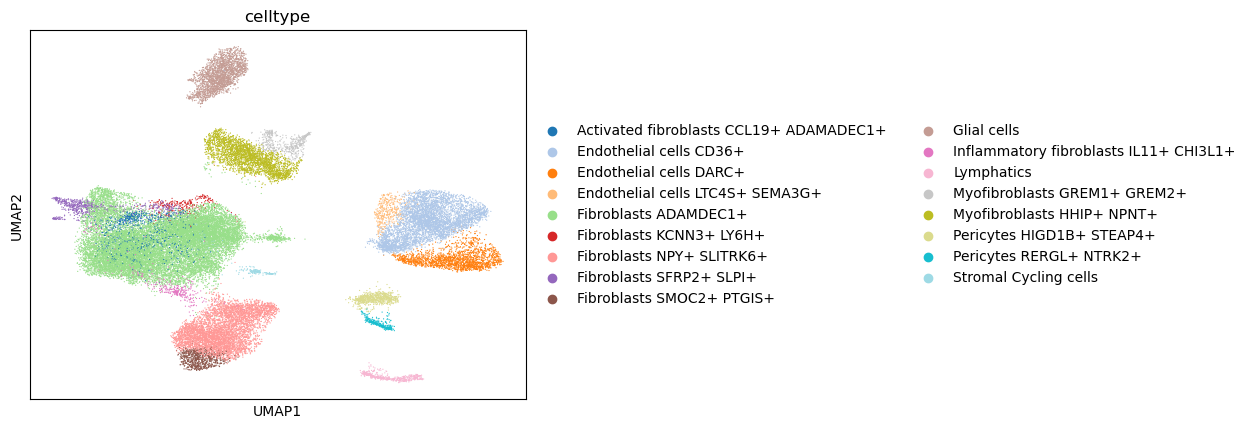

In [481]:
sc.pl.umap(adata, color=['celltype'], palette='tab20', save='all_cells_celltype.png"')

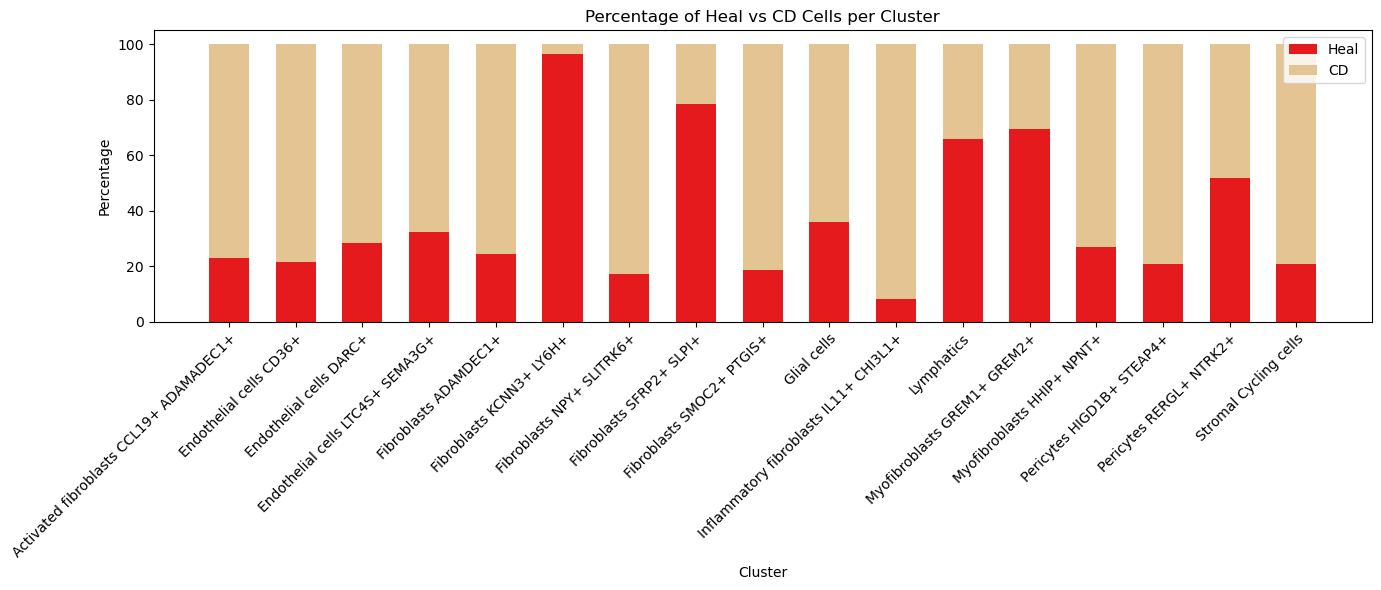

In [483]:
condition_stacked_bar_plot(adata, 'celltype', 'condition', 'Heal', 'CD', save='figures/all_cells_barplot.png')

In [387]:
actable = get_deg_table_with_cluster_column(adata, groupby='celltype')

acdict={}
for celltype in actable['group'].unique():
    acdict[celltype] = actable.loc[actable['group'] == celltype, 'gene'].head(5).tolist()

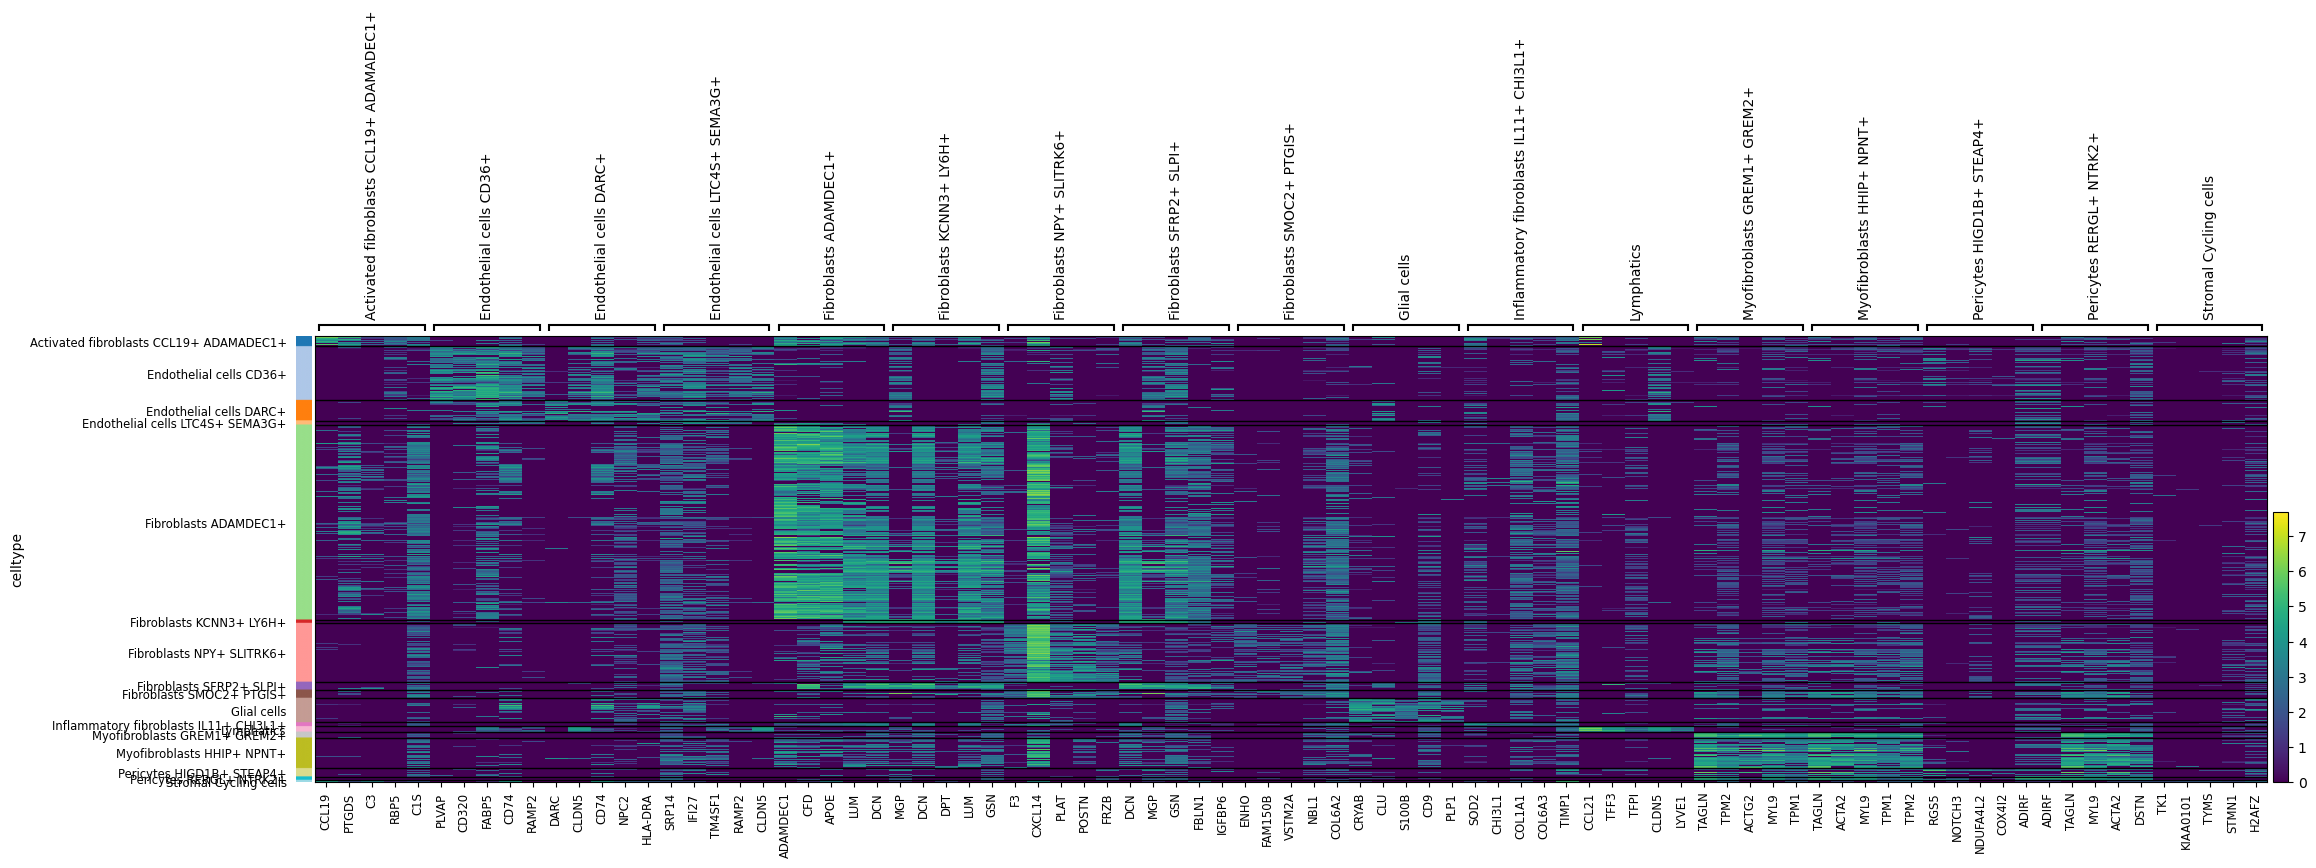

In [485]:
sc.pl.heatmap(adata, acdict, 'celltype', show_gene_labels=True, save='all_cells.png')

In [297]:
IL_list = pd.read_csv('/home/nim-lab/Desktop/Dow/human_integrated/group-602.csv')

In [298]:
IL_list = np.array(IL_list.loc[:, 'Approved symbol']) 

In [299]:
IL_list = np.append(IL_list, ['IFNAR1', 'IFNAR2', 'IFNGR1', 'IFNGR2', 'IFNLR1'])

In [301]:
IL_list = IL_list [~np.isin(IL_list, ['CXCR1', 'IL22RA2', 'IL9R'])]

In [390]:
ils = pd.read_csv('/home/nim-lab/Desktop/Dow/human_integrated/group-601.csv')

In [391]:
ils = ils['Approved symbol'].tolist()

In [394]:
ils = [il for il in ils if il not in ['CXCL8', 'IL36A']]

In [490]:
gbarcodes = adata.obs_names[(adata.obs['leiden']=='11') | (adata.obs['leiden']=='21')]

In [491]:
gadata

AnnData object with n_obs × n_vars = 39433 × 28663
    obs: 'batch', 'batch1', 'condition', 'location', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'

In [492]:
gbarcodes

Index(['N105446_L-GCTACCTTCCGATAAC', 'N110204_L-CAGATACTCTAGTGAC',
       'N110204_L-AGGACTTGTGTTTCTT', 'N110204_L-TGTCAGAAGTCGCTAT',
       'N110204_L-TTAGGGTTCCTGTAGA', 'N110204_L-CTCATGCCAGGGTTGA',
       'N110204_L-ATGCATGTCCGATCTC', 'N110204_L-CTGCCTAGTTACGATC',
       'N110204_L-AACGGGATCGCTTGCT', 'N110204_L-CAGCCAGGTAAGGCTG',
       ...
       'N130084_L-AGTCAACAGTCGGCCT', 'N130084_L-GCATGATAGAAGCCTG',
       'N130084_L-CCGCAAGTCAACCGAT', 'N130084_L-GAAACCTTCTCGTCAC',
       'N130084_L-GAGACCCTCATCCTGC', 'N130084_L-GCTGGGTCAGAGCTAG',
       'N130084_L-CTACCTGCACGTCTCT', 'N130084_L-GATGAGGGTGGGATTG',
       'N130084_L-CTTGATTGTACGATGG', 'N130084_L-TTCGCTGTCATCGTAG'],
      dtype='object', length=2164)

In [493]:
gadata = gadata[gadata.obs_names.isin(gbarcodes)]

In [494]:
gadata

View of AnnData object with n_obs × n_vars = 2164 × 28663
    obs: 'batch', 'batch1', 'condition', 'location', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'

In [412]:
mask_batches = ['N105446', 'N114902', 'N1108147']

In [413]:
gadata = gadata[~gadata.obs['batch'].isin(mask_batches)]

In [495]:
sc.pp.highly_variable_genes(
    gadata,
    flavor='seurat',
    batch_key='batch',
    n_top_genes=2000
)
gadata.raw = gadata.copy()
gadata = gadata[:, gadata.var.highly_variable].copy()

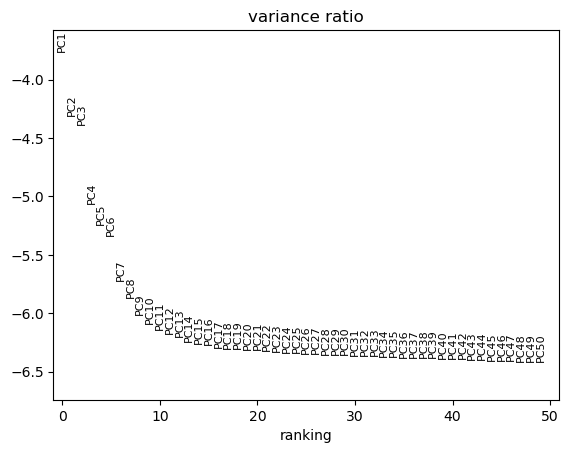

In [496]:
sc.pp.scale(gadata, max_value=10)
sc.tl.pca(gadata, svd_solver='arpack')
sc.pl.pca_variance_ratio(gadata, log=True, n_pcs = 50)

In [497]:
sc.external.pp.harmony_integrate(gadata, key='batch', max_iter_harmony=40)
sc.pp.neighbors(gadata, n_neighbors = 20, n_pcs = 20, use_rep='X_pca_harmony')
sc.tl.umap(gadata)

2025-07-17 18:53:11,377 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-07-17 18:53:11,515 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-07-17 18:53:11,534 - harmonypy - INFO - Iteration 1 of 40
2025-07-17 18:53:11,794 - harmonypy - INFO - Iteration 2 of 40
2025-07-17 18:53:12,041 - harmonypy - INFO - Iteration 3 of 40
2025-07-17 18:53:12,219 - harmonypy - INFO - Iteration 4 of 40
2025-07-17 18:53:12,397 - harmonypy - INFO - Iteration 5 of 40
2025-07-17 18:53:12,535 - harmonypy - INFO - Iteration 6 of 40
2025-07-17 18:53:12,643 - harmonypy - INFO - Iteration 7 of 40
2025-07-17 18:53:12,761 - harmonypy - INFO - Iteration 8 of 40
2025-07-17 18:53:12,869 - harmonypy - INFO - Iteration 9 of 40
2025-07-17 18:53:12,977 - harmonypy - INFO - Iteration 10 of 40
2025-07-17 18:53:13,085 - harmonypy - INFO - Iteration 11 of 40
2025-07-17 18:53:13,183 - harmonypy - INFO - Iteration 12 of 40
2025-07-17 18:53:13,300 - harmonypy - INFO - Iteration 13 of

In [498]:
sc.tl.leiden(gadata, resolution=0.5)

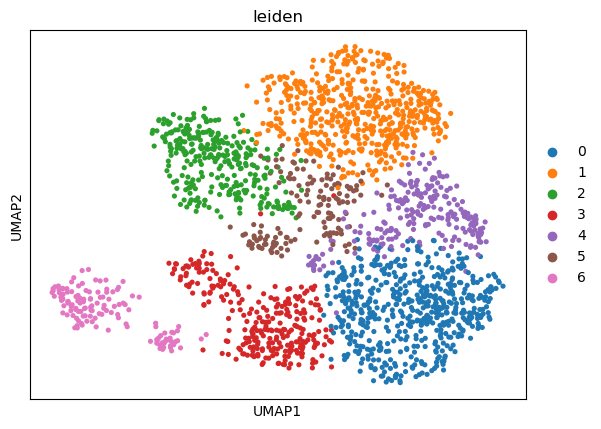

In [507]:
sc.pl.umap(gadata, color='leiden', save='glia_leiden')

In [315]:
ils = pd.read_csv('group-601.csv')

In [316]:
ils = ils.iloc[:,1].tolist()

In [317]:
ilss = np.intersect1d(ils, gadata.raw.var_names)

In [318]:
mask_genes = ['CXCL8', 'IL36A']

In [319]:
ils = [il for il in ils if il not in mask_genes]

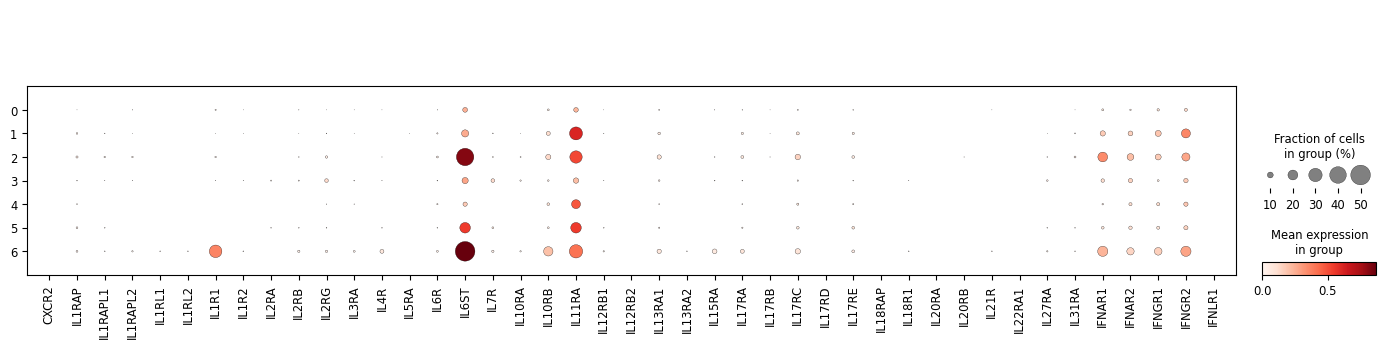

In [505]:
sc.pl.dotplot(gadata, IL_list, 'leiden', use_raw=True, save='glia_il_receptors')

In [508]:
for cluster in gadata.obs['leiden'].unique(): 
    table = get_deg_table(gadata, groupby='leiden', cluster=cluster)
    table.to_csv(f'deg/deg_glia_cluster_{cluster}.csv', index=False)

In [509]:
sc.write('checkpoint_h5ads/kong_all_cells.h5ad', adata)

In [510]:
sc.write('checkpoint_h5ads/kong_glia_cells.h5ad', gadata)